In [1]:
# import dependencies 
from fastai.vision.all import *
import timm
from torchvision import transforms
from pathlib import Path

e:\Users\Dalton\anaconda3\envs\plant_inspector\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Function to label the images (this might change based on your task)
def get_y(file_path): 
    return parent_label(file_path)

In [3]:
def create_dls(train_pct, path='PlantDoc'):
    # Define the DataBlock
    datablock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),  # Define types of input and output
        get_items=get_image_files,           # How to get the items (images)
        splitter=RandomSplitter(valid_pct=(1.0 - train_pct), seed=42),  # Split method
        get_y=get_y,                         # How to label items
        item_tfms=Resize(224),               # Item-level transformations
        # batch_tfms=aug_transforms()          # Batch-level transformations
    )
    # Create the DataLoaders
    dls = datablock.dataloaders(Path(path))
    return dls

In [4]:
def get_mean_table(results_table):
    # 1 & 2: Group by 'train_pct' and calculate the mean of 'acc'
    grouped = results_table.groupby('train_pct')['acc'].mean().reset_index()
    # 3: Create the new DataFrame
    mean_table = grouped.rename(columns={'acc': 'mean_acc'})
    return mean_table

In [5]:
# dls.show_batch()

In [6]:
train_pcts = [0.1, 0.25, 0.5, 0.65]
replicates = 1
results_table = pd.DataFrame(columns=['train_pct', 'acc'])
for train_pct in train_pcts:
    print(f'Creating DL: {train_pct}')
    dls = create_dls(train_pct)
    create_dls(train_pct)
    for replicate in range(replicates): # repeat training and average results for increased accuracy 
        print(f'{train_pct} replicate {replicate}')
        # fine tune model
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
        learn = Learner(dls, model, metrics=accuracy)
        learn.fine_tune(epochs=15)
        val_acc = learn.recorder.values[-1][2]
        row = pd.DataFrame({'train_pct': train_pct, 'acc': val_acc}, index=[0])
        results_table = pd.concat([results_table, row])

mean_table = get_mean_table(results_table)

Creating DL: 0.1


e:\Users\Dalton\anaconda3\envs\plant_inspector\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


0.1 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,4.118865,3.416676,0.109321,04:16


epoch,train_loss,valid_loss,accuracy,time
0,0.746045,3.227670,0.149826,03:26
1,0.471572,3.031231,0.202091,03:35
2,0.328037,2.869931,0.238240,03:36
3,0.242361,2.790696,0.280052,03:37
4,0.189107,2.892311,0.305749,03:36
5,0.152263,2.928753,0.326655,03:36
6,0.133073,2.764542,0.338415,03:36
7,0.116753,2.753703,0.341028,03:37
8,0.100112,2.800283,0.343641,03:37
9,0.086532,2.872450,0.339286,03:36


KeyboardInterrupt: 

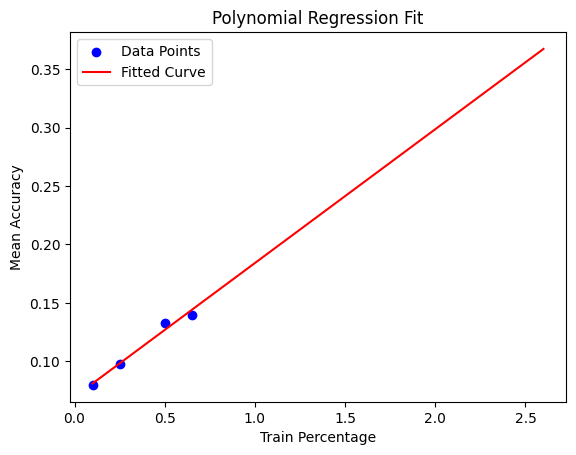

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'mean_table' is your DataFrame with 'train_pct' and 'mean_acc'
x = mean_table['train_pct']
y = mean_table['mean_acc']

# Choose the degree of the polynomial (e.g., 2 for quadratic)
degree = 1

# Fit the polynomial regression model
coefficients = np.polyfit(x, y, degree)

# Use the fitted model to predict values
polynomial = np.poly1d(coefficients)

# Extend the range of x_line beyond the maximum x value
x_min = min(x)
x_max = max(x)  # Maximum value in your data
x_extension = 4.0  # For example, extend by 20%
extended_x_max = x_max * x_extension

x_line = np.linspace(x_min, extended_x_max, 100)
y_line = polynomial(x_line)

# Plotting the original data points
plt.scatter(x, y, color='blue', label='Data Points')

# Plotting the fitted curve over the extended range
plt.plot(x_line, y_line, color='red', label='Fitted Curve')

plt.xlabel('Train Percentage')
plt.ylabel('Mean Accuracy')
plt.title('Polynomial Regression Fit')
plt.legend()
plt.show()


In [ ]:
percentage_of_data = 0.9
predicted_accuracy = polynomial(percentage_of_data)
predicted_accuracy

0.1611707501929916

In [ ]:
train_pcts = [0.9]
replicates = 1
results_table = pd.DataFrame(columns=['train_pct', 'acc'])
for train_pct in train_pcts:
    print(f'Creating DL: {train_pct}')
    dls = create_dls(train_pct)
    create_dls(train_pct)
    for replicate in range(replicates): # repeat training and average results for increased accuracy 
        print(f'{train_pct} replicate {replicate}')
        # fine tune model
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
        learn = Learner(dls, model, metrics=accuracy)
        learn.fine_tune(epochs=15)
        val_acc = learn.recorder.values[-1][2]
        row = pd.DataFrame({'train_pct': train_pct, 'acc': val_acc}, index=[0])
        results_table = pd.concat([results_table, row])

mean_table = pd.concat([mean_table, get_mean_table(results_table)])
mean_table = mean_table.reset_index()

Creating DL: 0.9


e:\Users\Dalton\anaconda3\envs\plant_inspector\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


0.9 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,5.360591,4.668133,0.066667,01:41


epoch,train_loss,valid_loss,accuracy,time
0,3.648805,3.995938,0.074510,01:27
1,3.487367,3.580865,0.098039,01:28
2,3.337499,3.460771,0.109804,01:28
3,3.242939,3.404672,0.101961,01:30
4,3.159148,3.221996,0.129412,01:33
5,3.063908,3.155431,0.149020,01:30
6,2.982043,3.097251,0.117647,01:30
7,2.873913,3.041114,0.176471,01:29
8,2.765105,2.969723,0.160784,01:29
9,2.667643,2.950239,0.152941,01:30


C:\Users\Dalton\AppData\Local\Temp\ipykernel_1536\3683552236.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_table = pd.concat([results_table, row])


In [ ]:
# plot polynomial here

In [ ]:
from scipy.optimize import fsolve

# Set your target accuracy
target_accuracy = 0.70  # Adjust this as needed

# Define the function to find roots
# This function represents the polynomial equation - target_accuracy = 0
def equation(train_pct):
    return polynomial(train_pct) - target_accuracy

# Initial guess for train_pct - it's important to choose a reasonable starting point
initial_guess = 0.5

# Solving the equation
predicted_train_pct = fsolve(equation, initial_guess)

print(f"Predicted train_pct for achieving {target_accuracy} accuracy: {predicted_train_pct[0]}")


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Prepare the data
X = mean_table[['mean_acc']]  # Independent variable
y = mean_table['train_pct']  # Dependent variable

# We can use a polynomial regression model
# Choose a degree for polynomial features
degree = 2
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Train the model
model = LinearRegression()
model.fit(X_poly, y)

# Predict the required train_pct for a given accuracy
desired_accuracy = 0.42
predicted_train_pct = model.predict(poly.transform([[desired_accuracy]]))

print(f"Predicted train_pct for achieving {desired_accuracy} accuracy: {predicted_train_pct[0]}")


In [ ]:
# Resnet-18
# epoch	train_loss	valid_loss	accuracy	time
# 0	2.329669	2.175517	0.398039	04:44
# 1	2.047739	1.710715	0.527451	04:47
# 2	1.696105	1.822478	0.431373	04:57
# 3	1.373082	1.125379	0.621569	05:14
# 4	1.118939	1.178962	0.613725	05:16
# 5	0.903016	1.063396	0.656863	05:16
# 6	0.726309	0.970530	0.662745	05:16
# 7	0.587566	0.937186	0.670588	05:15
# 8	0.492905	0.925825	0.688235	05:04
# 9	0.435941	0.922592	0.692157	04:56

In [ ]:
learn.save('fine_tuned_model')